In [1]:
import pandas as pd

from sadie.renumbering import Renumbering

from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

In [3]:
from typing import Any, Dict, Optional

import pandas as pd
from pydantic import BaseModel, Field, root_validator

## Define the sequences
These are the sequences that we are using for this annotation

In [2]:
pg9_seq = "CAGCGATTAGTGGAGTCTGGGGGAGGCGTGGTCCAGCCTGGGTCGTCCCTGAGACTCTCCTGTGCAGCGTCCGGATTCGACTTCAGTAGACAAGGCATGCACTGGGTCCGCCAGGCTCCAGGCCAGGGGCTGGAGTGGGTGGCATTTATTAAATATGATGGAAGTGAGAAATATCATGCTGACTCCGTATGGGGCCGACTCAGCATCTCCAGAGACAATTCCAAGGATACGCTTTATCTCCAAATGAATAGCCTGAGAGTCGAGGACACGGCTACATATTTTTGTGTGAGAGAGGCTGGTGGGCCCGACTACCGTAATGGGTACAACTATTACGATTTCTATGATGGTTATTATAACTACCACTATATGGACGTCTGGGGCAAAGGGACCACGGTCACCGTCTCGAGC"
pg9_aa = "QRLVESGGGVVQPGSSLRLSCAASGFDFSRQGMHWVRQAPGQGLEWVAFIKYDGSEKYHADSVWGRLSISRDNSKDTLYLQMNSLRVEDTATYFCVREAGGPDYRNGYNYYDFYDGYYNYHYMDVWGKGTTVTVSS"

## Renumberring HMM

Renumbering module in Sadie uses HMMER to annotate the antibody sequences.  

In [1]:
import pandas as pd

from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.SeqFeature import FeatureLocation, SeqFeature

from sadie.renumbering import Renumbering

class ProteinSequenceProcessor:
    def __init__(self, sequence, seq_name, molecule_type='protein',
                 organism="Human", scheme="imgt", region_assign="imgt", 
                 run_multiproc=False):
        self.sequence = sequence
        self.scheme = scheme
        self.organism = organism
        self.name = seq_name
        self.type = molecule_type
        self.region_assign = region_assign
        self.run_multiproc = run_multiproc
        self.map_number = {
            "FWR1": 'v_gene',
            "CDR1": 'v_gene',
            "FWR2": 'v_gene',
            "CDR2": 'v_gene',
            "FWR3": 'v_gene',
            "CDR3": 'd_gene',
            "FWR4": 'j_gene',
            "VGene": 'v_gene',
             "DGene": 'd_gene',
            "JGene": 'j_gene',
        }

    def process_sequence(self):
        renumbering_api = Renumbering(scheme=self.scheme, region_assign=self.region_assign, run_multiproc=self.run_multiproc)

        # Run sequence and return renumbering table with sequence_id and sequence
        numbering_table = renumbering_api.run_single(self.name, self.sequence)

        seq = Seq(self.sequence)
        record = SeqRecord(id=self.name, seq=seq, name=self.name)
        record.annotations["molecule_type"] = self.type
        record.annotations["organism"] = numbering_table.hmm_species[0]

        for feature in self.map_number.keys():
            _feature = self._get_feature_numbering(numbering_table, feature)
            if _feature:
                record.features.append(_feature)

        return record

    def _get_start_stop(self, feature, numbering_table):
        start = self.sequence.find(numbering_table[f'{feature.lower()}_aa_no_gaps'][0])
        end = start + len(numbering_table[f'{feature.lower()}_aa_no_gaps'][0])
        return start, end

    def _get_feature_numbering(self, numbering_table, feature):
        feature_type = feature
        if feature in ['VGene', 'JGene', 'DGene']:
            return None  # The numbering scheme is missing these details (will try and get FW and CDR later)
        else:
            start, end = self._get_start_stop(feature, numbering_table)
            qualifier_dict = {'reference': numbering_table.hmm_species[0]}
            try:
                qualifier_dict['gene'] =  [numbering_table[self.map_number[feature_type]][0]]
            except KeyError:
                qualifier_dict['gene'] = 'Missing'
            location = FeatureLocation(start, end)
            _feature = SeqFeature(location, type=feature_type, qualifiers=qualifier_dict)

        return _feature

if __name__ == "__main__":
    seg_name = 'PG9'
    pg9_aa = "QRLVESGGGVVQPGSSLRLSCAASGFDFSRQGMHWVRQAPGQGLEWVAFIKYDGSEKYHADSVWGRLSISRDNSKDTLYLQMNSLRVEDTATYFCVREAGGPDYRNGYNYYDFYDGYYNYHYMDVWGKGTTVTVSS"
    processor = ProteinSequenceProcessor(pg9_aa, seg_name)
    genbank_record = processor.process_sequence()
    print(genbank_record.format('genbank'))


LOCUS       PG9                      136 aa                     UNK 01-JAN-1980
DEFINITION  .
ACCESSION   PG9
VERSION     PG9
KEYWORDS    .
SOURCE      .
  ORGANISM  human
            .
FEATURES             Location/Qualifiers
     FWR1            1..24
                     /reference="human"
                     /gene="IGHV3-30*02"
     CDR1            25..32
                     /reference="human"
                     /gene="IGHV3-30*02"
     FWR2            33..49
                     /reference="human"
                     /gene="IGHV3-30*02"
     CDR2            50..57
                     /reference="human"
                     /gene="IGHV3-30*02"
     FWR3            58..95
                     /reference="human"
                     /gene="IGHV3-30*02"
     CDR3            96..125
                     /reference="human"
                     /gene="Missing"
     FWR4            126..136
                     /reference="human"
                     /gene="IGHJ6*04"
ORIGIN
        

## Now we can write the  record to file and visualize

In [120]:
with open(f'output/{seg_name}_hmmer.gb',"w") as handle:
    SeqIO.write(genebank_record,handle,"genbank")

### And Visualize the record using Geneious

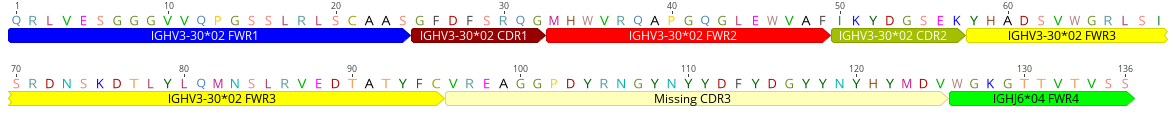

In [109]:
from IPython import display
display.Image("images/HMMER_Sadie_Annotation.png")

## BLAST Annotation Using SADIE
Uses igblastn here to annotate the sequence provided. This is run through the AIRR API, which calls igblast. It can take a single sequence, fasta, or a directory with several files. The output is an AirrTable, which inherits from pandas dataframe and has the same functionalities, plus afew more. We parse the AirTable to get the features added to genbank annotation. 

In [104]:
## Alternative processor that can take both sequence and nuc ID for annotation

In [116]:
import pandas as pd

from sadie.airr import Airr

from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.SeqFeature import FeatureLocation, SeqFeature
from Bio import SeqIO
from Bio import Entrez

class GenBankProcessor:
    def __init__(self, email, gene_id, airr_species="human"):
        Entrez.email = email
        self.gene_id = gene_id
        self.airr_api = Airr(airr_species)
    
    def fetch_genebank_record(self):
        try:
            handle = Entrez.efetch(db='nucleotide', id=self.gene_id, rettype='gb')
            genebank_record = list(SeqIO.parse(handle, "genbank"))[0]
            return genebank_record
        except Exception as e:
            print(f"Error fetching GenBank record: {e}")
            return None

    def get_airr_table(self, gene_symbol, sequence):
        return self.airr_api.run_single(gene_symbol, sequence)


class GenBankFeatureAdder:
    def __init__(self, genebank_record, map_dict):
        self.genebank_record = genebank_record
        self.map_dict = map_dict

    def add_feature(self, feature, airr_table):
        feature_type = feature
        if feature in ['VGene', 'JGene', 'DGene']:
            start = int(airr_table[f'{feature_type.lower()[0]}_sequence_start'][0]) - 1
            end = int(airr_table[f'{feature_type.lower()[0]}_sequence_end'][0])
            qualifier_dict = {
                'gene': [airr_table[self.map_dict[feature_type]][0]],
                'species': [airr_table['reference_name'][0]]
            }
        else:
            start = int(airr_table[f'{feature_type.lower()}_start'][0]) - 1
            end = int(airr_table[f'{feature_type.lower()}_end'][0])
            qualifier_dict = {
                'gene': [airr_table[self.map_dict[feature_type]][0]],
                'reference': [airr_table['reference_name'][0]]
            }

        location = FeatureLocation(start, end)
        _feature = SeqFeature(location, type=feature_type, qualifiers=qualifier_dict)
        self.genebank_record.features.append(_feature)
def get_record_from_seq(seq, seq_id, seq_name):
    seq = Seq(seq)
    record = SeqRecord(id=seq_id, seq=seq, name=seq_name)
    record.annotations["molecule_type"] = "DNA"
    return record

#genbank_record = get_record_from_seq(seq, seq_id, seq_name)

def main(email=None, gene_id=None, seq=None, seq_id=None, seq_name=None):
    map_dict = {
        "FWR1": 'v_call',
        "FWR2": 'v_call',
        "FWR3": 'v_call',
        "FWR4": 'j_call',
        "CDR1": 'v_call',
        "CDR2": 'v_call',
        "CDR3": 'd_call',
        "VGene": 'v_call',
        "JGene": 'j_call',
        "DGene": 'd_call'
    }

    if seq is not None:
        processor = GenBankProcessor(email, gene_id)
        genbank_record = get_record_from_seq(seq, seq_id, seq_name)
        #print(genbank_record.seq)
    else:
        processor = GenBankProcessor(email, gene_id)
        genbank_record = processor.fetch_genebank_record()
        #print('Also got here')

    feature_types = [
        "FWR1",
        "CDR1",
        "FWR2",
        "CDR2",
        "FWR3",
        "CDR3",
        "FWR4",
        'VGene',
        'DGene',
        'JGene'
    ]

    for feature in feature_types:
        airr_table = processor.get_airr_table(feature, genbank_record.seq)
        feature_adder = GenBankFeatureAdder(genbank_record, map_dict)
        feature_adder.add_feature(feature, airr_table)
    print(genbank_record.format('genbank'))
    return genbank_record
    
if __name__ == "__main__":
    email = 'example@mail.com'
    gene_id = 'GU272045.1'
    pg9_seq = "CAGCGATTAGTGGAGTCTGGGGGAGGCGTGGTCCAGCCTGGGTCGTCCCTGAGACTCTCCTGTGCAGCGTCCGGATTCGACTTCAGTAGACAAGGCATGCACTGGGTCCGCCAGGCTCCAGGCCAGGGGCTGGAGTGGGTGGCATTTATTAAATATGATGGAAGTGAGAAATATCATGCTGACTCCGTATGGGGCCGACTCAGCATCTCCAGAGACAATTCCAAGGATACGCTTTATCTCCAAATGAATAGCCTGAGAGTCGAGGACACGGCTACATATTTTTGTGTGAGAGAGGCTGGTGGGCCCGACTACCGTAATGGGTACAACTATTACGATTTCTATGATGGTTATTATAACTACCACTATATGGACGTCTGGGGCAAAGGGACCACGGTCACCGTCTCGAGC"
    id='PG9-Antibody'
    seq_name='PG9'

    # Fetch the genbank file and annotate 
    genebank_record = main(seq=pg9_seq, seq_id=id, seq_name=seq_name)
    with open(f'output/{id}_airr.gb',"w") as handle:
        SeqIO.write(genebank_record,handle,"genbank")
    # Can use a provided sequence
    #main(email=email, gene_id=gene_id)

LOCUS       PG9                      408 bp    DNA              UNK 01-JAN-1980
DEFINITION  .
ACCESSION   PG9-Antibody
VERSION     PG9-Antibody
KEYWORDS    .
SOURCE      .
  ORGANISM  .
            .
FEATURES             Location/Qualifiers
     FWR1            1..72
                     /gene="IGHV3-33*05"
                     /reference="human"
     CDR1            73..96
                     /gene="IGHV3-33*05"
                     /reference="human"
     FWR2            97..147
                     /gene="IGHV3-33*05"
                     /reference="human"
     CDR2            148..171
                     /gene="IGHV3-33*05"
                     /reference="human"
     FWR3            172..285
                     /gene="IGHV3-33*05"
                     /reference="human"
     CDR3            286..375
                     /gene="IGHD3-3*01"
                     /reference="human"
     FWR4            376..408
                     /gene="IGHJ6*03"
                     /reference=

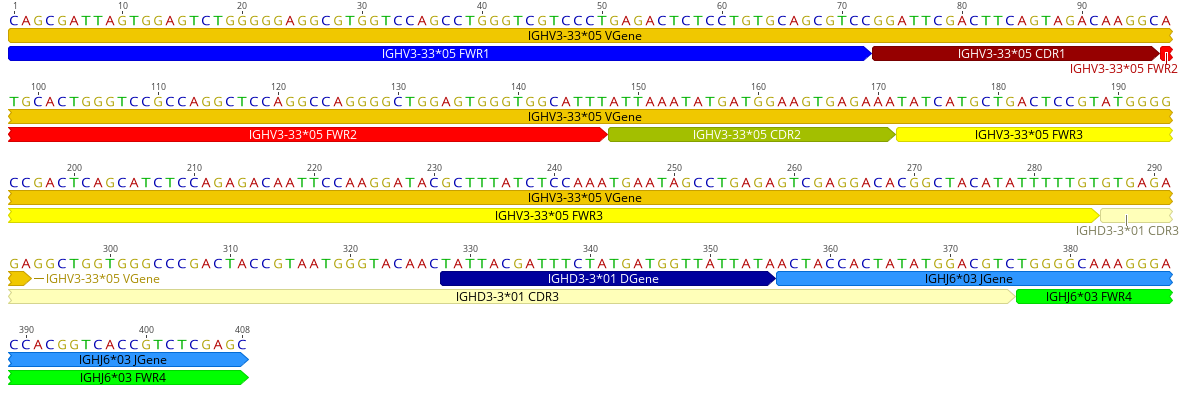

In [118]:
from IPython import display
display.Image("images/AIRR_Annotation_incomplete.png")

We can also generate one, which includes the rest of the features by fetching from NCBI

In [117]:
if __name__ == "__main__":
    email = 'example@mail.com'
    gene_id = 'GU272045.1'
    #pg9_seq = "CAGCGATTAGTGGAGTCTGGGGGAGGCGTGGTCCAGCCTGGGTCGTCCCTGAGACTCTCCTGTGCAGCGTCCGGATTCGACTTCAGTAGACAAGGCATGCACTGGGTCCGCCAGGCTCCAGGCCAGGGGCTGGAGTGGGTGGCATTTATTAAATATGATGGAAGTGAGAAATATCATGCTGACTCCGTATGGGGCCGACTCAGCATCTCCAGAGACAATTCCAAGGATACGCTTTATCTCCAAATGAATAGCCTGAGAGTCGAGGACACGGCTACATATTTTTGTGTGAGAGAGGCTGGTGGGCCCGACTACCGTAATGGGTACAACTATTACGATTTCTATGATGGTTATTATAACTACCACTATATGGACGTCTGGGGCAAAGGGACCACGGTCACCGTCTCGAGC"
    #id='PG9-Antibody'
    #seq_name='PG9'

    #Fetch the genbank file and annotate 
    #main(seq=pg9_seq, seq_id=id, seq_name=seq_name)

    # Can use a provided sequence
    genbank_record = main(email=email, gene_id=gene_id)
    with open(f'output/{id}_complete.gb',"w") as handle:
        SeqIO.write(genbank_record,handle,"genbank")

LOCUS       GU272045                 408 bp    mRNA    linear   PRI 24-JUL-2016
DEFINITION  Homo sapiens isolate PG9 anti-HIV immunoglobulin heavy chain
            variable region mRNA, partial cds.
ACCESSION   GU272045
VERSION     GU272045.1
KEYWORDS    .
SOURCE      Homo sapiens (human)
  ORGANISM  Homo sapiens
            Eukaryota; Metazoa; Chordata; Craniata; Vertebrata; Euteleostomi;
            Mammalia; Eutheria; Euarchontoglires; Primates; Haplorrhini;
            Catarrhini; Hominidae; Homo.
REFERENCE   1  (bases 1 to 408)
  AUTHORS   Walker,L.M., Phogat,S.K., Chan-Hui,P.Y., Wagner,D., Phung,P.,
            Goss,J.L., Wrin,T., Simek,M.D., Fling,S., Mitcham,J.L.,
            Lehrman,J.K., Priddy,F.H., Olsen,O.A., Frey,S.M., Hammond,P.W.,
            Kaminsky,S., Zamb,T., Moyle,M., Koff,W.C., Poignard,P. and
            Burton,D.R.
  CONSRTM   Protocol G Principal Investigators
  TITLE     Broad and potent neutralizing antibodies from an African donor
            reveal a new 

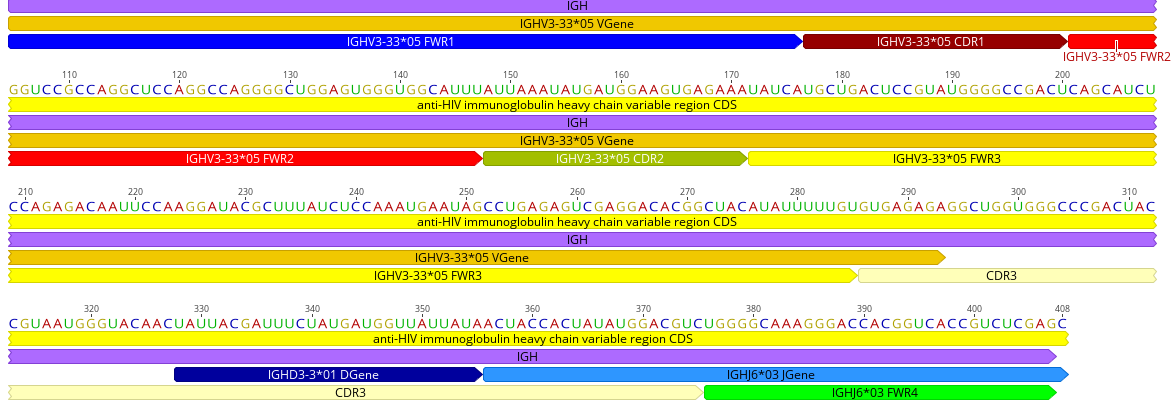

In [119]:
from IPython import display
display.Image("images/AIRR_Annotation.png")